Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook e sua versão online pode ser encontrada aqui: https://colab.research.google.com/drive/1HQIBTnHCrcSrfAUOsx7836wZzDnQ9Fhd?usp=sharing. Nessa versão é possível executar novamente os algoritmos.
A resolução dos problemas não seguiu a mesma ordem do descrito no trabalho, todavia eu sempre começo pela introdução do problema em questão.

# Qual o problema ? 
Possuímos a seguinte equação matemática:

![title](image/equacao.png)

Queremos descobrir qual o valor de **X** que gera um maior resultado. Não temos a resposta exata, ou seja, não sabemos o quanto essa função pode ser maximizada, portanto quanto maior o valor que conseguimos melhor.

## Representação 
O domínio do problema se dá em um intervalo de [0, 1], o **X** pode assumir qualquer valor dentro dessa faixa.

## Objetivo

O objetivo é **maximizar** o resultado da equação, encontrando o valor X, dentro do domínio, que vai gerar o maior valor possível. O melhor valor será definido por aquele que tiver o maior resultado final dentre todas as soluções encontradas, pois como já foi dito, não sabemos qual o nosso máximo global.

## Codificando
Vamos começar com a importação das bibliotecas usadas, não só para esse problema mas para todos os outros também.

In [49]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

## Criação da função de custo / avaliação
A função de custo é o coração dos algoritmos de otimização, todos eles tem essa função que é responsável por indicar a aptidão/desempenho que a solução candidata possui.
A otimização da solução gira em torno dessas nossas funções de custo, pois sempre vamos fazer de tudo para maximizar ou minimizar o valor proveniente da função. Nesse caso, a função de custo é dada simplesmente pelo resultado da equação mostrada anteriormente.

In [50]:
def funcao_custo(x):
    #caso o valor seja uma tupla Ex: (0.23) ele deve virar um int Ex: 0.23
    if isinstance(x, tuple):
        x = x[0]

    custo = 2 ** (-2 *((((x-0.1) / 0.9)) ** 2)) * ((math.sin(5*math.pi*x)) ** 6)
    return custo

## Exibindo os resultados
Todos os algoritmos que serão executados vão ter os resultados exibidos por meio de um gráfico, que vai mostrar o melhor resultado ao longo das iterações e também por meio de um *print* no console com as informações numéricas de desempenho. Para isso, utilizamos as duas funções implementadas abaixo.

A função de *plotar_busca* é a que gera nosso gráfico, onde o **eixo Y** é o custo/aptidão do algoritmo e o **eixo X** é o número de iterações que foram executadas. Pelo fato dos algoritmos serem estocásticos, eles foram executados várias vezes, portanto o objetivo desse gráfico é nos mostrar os melhores resultados obtidos em cada uma dessas execuções.

A função *exibir_sumario_resultados*, por outro lado, nos exibe na tela o resultado final do algoritmo baseado em todas as suas execuções, trazendo a média, desvio padrão, melhor aptidão/custo e valor da solução que teve o melhor custo. Lembrando que os resultados do algoritmo podem ser no sentido de maximização ou minimização de um valor, por isso um dos parâmetros dessa função é a escolha desse objetivo.

In [51]:
def plotar_busca(resultados):
    t = np.arange(0.0, len(resultados), 1)
    
    plt.figure(figsize=(12,8))
    plt.xlabel('N° iterações', fontsize=18)
    plt.ylabel('Custo', fontsize=16)
    plt.plot(t, resultados)
    plt.show()

In [52]:
def exibir_sumario_resultados(solucao, custos, objetivo = max):
    print('Solução que gerou melhor resultado:', solucao[custos.index(objetivo(custos))])
    print('Melhor custo:', objetivo(custos))
    print('Média de custos:', np.mean(custos))
    print('Desvio padrão:', np.std(custos))
    plotar_busca(custos)

## Pegando os vizinhos
A função *get_vizinhos* é usada para pegar os vizinhos no espaço de busca de cada dimensão  da solução. Nesse problema temos uma única dimensão, que é o valor da variável X na fórmula matemática. Dessa forma, vamos pegar os vizinhos possíveis do nosso X, sendo o valor superior e inferior ao X atual, configurando os movimentos que ele poderá fazer pelo espaço de busca em cada iteração. O "vizinho" nada mais é que uma **perturbação** na nossa solução X atual, podendo ser uma **constante** (que foi o escolhido nesse caso) ou usar, por exemplo, a fórmula gaussiana para determinar o valor dessa perturbação. A constante conseguiu explorar bem o espaço de busca, porém a sua grandeza foi escolhida baseada em testes de desempenho.

Ainda na função de *get_vizinhos*, temos também um parâmetro não obrigatório de taxa de aprendizado, que pode ser usado para reduzir o valor da constante baseado nas iterações do algoritmo, fazendo com que os passos dados na nossa busca sejam menores conforme as iterações. Com isso, temos um passo maior a princípio, fazendo com que a exploração pelo espaço de busca comece de forma mais rápida, porém ele desacelera com o passar das iterações, diminuindo o risco de pularmos nosso máximo global por estar com um "passo" muito grande.

Por fim, também foram adicionados operadores condicionais para garantir que os vizinhos estejam dentro do domínio do problema.

## Constante para pegar os vizinhos
Nossa constante foi definida baseada em testes, executando o algoritmo de subida da encosta 30 vezes para cada valor da constante, sendo este o único parâmetro alterado em cada execução. Conseguimos os seguintes resultados.

| Constante  | Custo  | valor X  | Média  | Desvio Padrão |
|---|:-:|:-:|:-:|:-:|
| 0.5  | 0.99  | 0.098  | 0.41  |  0.25 |
| 0.05  | 0.94  | 0.091  | 0.65  | 0.21  |
| 0.005  | 0.99  | 0.099  | 0.73  | 0.25  |
| 0.0005  | 0.99  | 0.099  | 0.69  | 0.22
| 0.00005  | 0.92  | 0.090  | 0.23  | 0.23

O valor final escolhido para nossa constante foi o de **0.005**, por conseguir um custo de 0.99, além de ter uma média mais alta nas 30 execuções do que os demais, fazendo com que seja vantajoso ainda que não tenha o menor desvio padrão.

In [53]:
def get_vizinhos(solucao, tx_aprendizado = 1):
    vizinhos = []
    constante = 0.005 / tx_aprendizado
    vizinho_superior = solucao + constante if solucao + constante < 1 else solucao
    vizinho_inferior = solucao - constante if solucao - constante > 0 else solucao
    
    vizinhos.append(vizinho_superior)
    vizinhos.append(vizinho_inferior)
    return vizinhos

## Pegando valor aleatório espaçado
A função de *get_valor_aleatório* vai garantir que meus valores aleatórios iniciais tenham uma diferença mínima entre eles. Essa função foi criada porque os algoritmos, principalmente o Hill Climbing, dependem de sua inicialização, uma vez que iniciar em um ponto favorável gera resultados consideravelmente melhores do que em um ponto não favorável.

Com isso, damos maior capacidade de exploração no espaço de busca para algoritmos que são mais fortes na explotação, através de multiplas inicializações. Esse espaço mínimo foi definido por uma constante e sua grandeza deve ser de acordo com o tamanho do domínio do problema. Nesse caso, nossa função recursiva tenta criar um novo ponto aleatório que tenha uma diferença de pelo menos 0.08 (valor escolhido baseado em testes) dos demais pontos existentes.

Um dos critérios de parada dessa função é o número de 300 execuções, caso ela não consiga encontrar um valor aleatório que tenha uma diferença maior ou igual a nossa constante, ele retorna o último valor aleatório que foi gerado. Isso é importante para não ficarmos presos em uma recursão infinita.

In [54]:
def get_valor_aleatorio(espaco, x=0):
    inicio = random.random()
    valor = []
    
    for i in espaco:
        diferenca = i - inicio
        if diferenca > 0.08 or diferenca < -0.08:
            valor.append(diferenca)

    if len(valor) == len(espaco) or x > 300:
        return inicio
    else:
        return get_valor_aleatorio(espaco, x = x + 1)

# Hill Climbing
O primeiro algoritmo para resolver o problema foi o Hill Climbing, definido pela função *hill_climbing*.
Os critérios de parada são:
- Atingir 400 iterações
- Ficar 20 iterações sem melhoria
- Ter apenas vizinhos piores que a solução atual
    
O segundo critério é chamado de **parada no platô**. A ideia da parada no platô é valida caso nosso algoritmo fique preso em uma armadilha chamada de "maximo local reto", como podemos ver na imagem. Sem esse critério de parada, nosso algoritmo iria precisar ser executado pelas 400 iterações, mas para nós seria uma perda de tempo, pois não haveria melhora nos resultados. Contudo, esse parâmetro de platô deve ser escolhido com cuidado, pois caso tenhamos caído em um "ombro (shoulder)" existe a esperança de melhoria.
    
![title](image/hill-climbing.png)

## Escolha dos parâmetros
Por se tratar de um problema com o domínio muito pequeno o número de 400 iterações não faz sentido, pois na prática o algoritmo não passou de 21 iterações, todavia não é necessário se preocupar com a otimização desse critério, pois a execução é extremamente rápida.

O parâmetro de **20 iterações** sem melhoria também foi arbitrário, pois em todos os testes executados o algoritmo não teve nenhum platô e quase nunca se deparava com um "ombro", portanto também não é um parâmetro tão importante de se preocupar para esse problema.

Por fim, Não foi usado uma semente para o processo de geração "aleatória" do valor inicial para não remover a propriedade estocástica do algoritmo, principalmente pelo fato que foram realizadas diversas execuções.

In [55]:
def hill_climbing(funcao_custo, solucao_inicial, tx_aprendizado = 1):
    solucao = solucao_inicial
    custos = []
    count = 0
    parar_no_plato = 0

    while count <= 400:
        vizinhos = get_vizinhos(solucao, tx_aprendizado)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            custo = funcao_custo(vizinhos[i])
            if custo >= melhor:
                parar_no_plato = parar_no_plato + 1 if custo == melhor else 0
                melhor = custo
                solucao = vizinhos[i]

        count += 1
        if melhor == atual and solucao_atual == solucao or parar_no_plato == 20:
            if parar_no_plato == 20: print('parada no platô')
            break

    return solucao, custos

## Execução e avaliação do Hill Climbing
Possuímos diversas formas de se inicializar e executar o algoritmo de subida da encosta para tentar buscar melhores resultados, portanto, foram feitos testes com diferentes parâmetros e metodologias. O Hill Climbing, por ser muito explotatório, depende de várias inicializações para tentar encontrar um "ponto global", por isso em cada teste o algoritmo é executado 30 vezes.

A função *executar_hill_climbing* possui os parâmetros que vão modificar a forma como o hill climbing vai se comportar na busca por melhores soluções. Abaixo vamos discutir cada uma das execuções que o hill climbing foi submetido e os diferentes resultados.

A maioria dos valores discutidos nos testes vão ser diferentes cada vez que o algoritmo executar, devido à aleatoriedade envolvida. Também podemos ver o tempo de execução em segundos do algoritmo.

In [56]:
def executar_hill_climbing(funcao_custo, iteracoes, espaco_minimo = False, 
                           get_melhor_resultado = False):
    
    start_time = time.time()
    custos = []
    solucao = []
    espaco_solucao = []
    
    for i in range(iteracoes):
        espaco_solucao.append(get_valor_aleatorio(espaco_solucao))
        
        valor_inicial = random.random() if espaco_minimo == False else espaco_solucao[
            len(espaco_solucao) - 1]   
        
        solucao_subida_encosta = hill_climbing(funcao_custo, valor_inicial) if get_melhor_resultado == False else hill_climbing(funcao_custo, solucao[
                custos.index(max(custos))] if len(custos) > 0 else random.random(), i + 1)
        
        solucao.append(solucao_subida_encosta[0])
        custos.append(max(solucao_subida_encosta[1]))
        custo_individual = solucao_subida_encosta[1]
        
    print("--- %s Segundos ---" % (time.time() - start_time))
    return solucao, custos, custo_individual

### Inicialização aleatória
No primeiro teste, o algoritmo foi inicializado com um valor aleatório dentro do nosso domínio [0,1] pelas 30 iterações, sendo a forma mais simples de se tentar obter os resultados.

In [57]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30)
# os algoritmos estão exibindo o tempo de execução em segundos, como é possível ver abaixo.

--- 0.04509711265563965 Segundos ---


Solução que gerou melhor resultado: 0.10020291870862219
Melhor custo: 0.9999694506293316
Média de custos: 0.7422470380881526
Desvio padrão: 0.2317938749603492


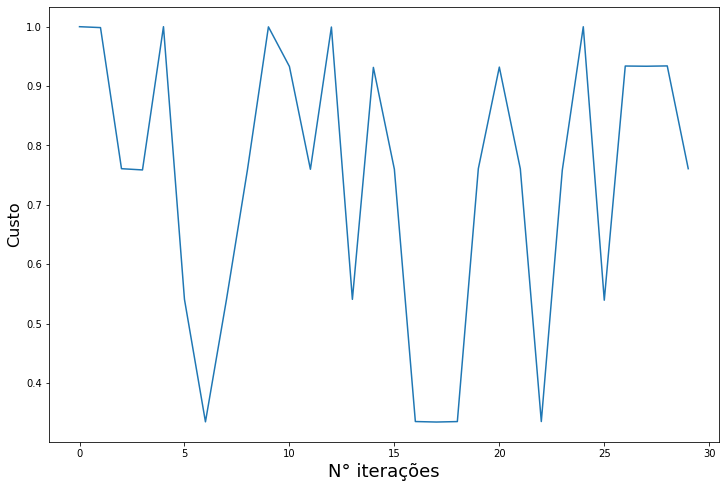

In [58]:
exibir_sumario_resultados(solucao, custos)

Como podemos ver, conseguimos atingir o valor X de 0.1, chegando a um custo de 0.99. Porém fica claro no gráfico a enorme variáção dos resultados cada vez que o algoritmo é inicializado e isso se reflete nas médias e desvio padrão das 30 execuções, gerando um algoritmo bastante instável.

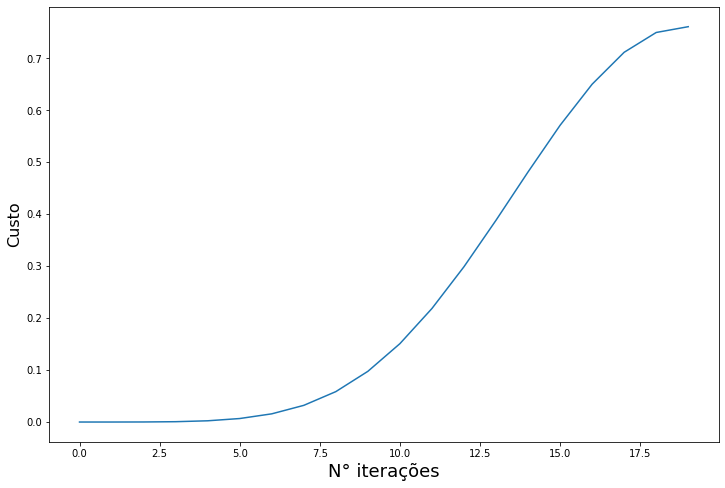

In [59]:
plotar_busca(grafico_subida_encosta)

Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de subida da encosta é sempre fazer esse movimento linear positivo, pois ele sempre tenta melhorar seus resultados. Na pior das hipóteses teremos uma linha reta constante.

### Explorando o espaço de busca
No segundo teste, usamos nossa função *get_valor_aleatório* para garantir um espaçamento entre os valores randômicos iniciais, aumentando a exploração do espaço de busca.

In [60]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True)
#3 parâmetro "espaco_minimo" recebe o valor de true

--- 0.024957895278930664 Segundos ---


Solução que gerou melhor resultado: 0.09961488067410758
Melhor custo: 0.9998899643630442
Média de custos: 0.7778027467931252
Desvio padrão: 0.22879883977969243


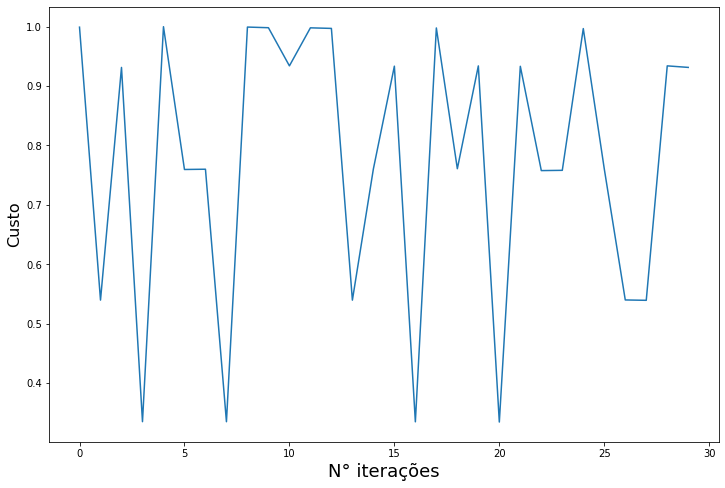

In [61]:
exibir_sumario_resultados(solucao, custos)

É possível observar que os resultados não mudaram muito em relação à versão anterior. Possivelmente se tivéssemos um espaço de busca maior do que [0,1] essa abordagem seria mais impactante para os resultados, todavia, não foi efetivo nesse contexto.

### Limitando o espaço de busca
A ideia no terceiro teste é iniciar o algoritmo não de forma aleatória, mas baseado nos resultados obtidos anteriormente, fazendo com que nosso foco esteja no espaço de busca onde foram encontrados os melhores resultados. Claro que apenas iniciar com o melhor valor da execução anterior sem modificar a forma como obtemos os vizinhos não seria bom, pois a execução anterior foi interrompida justamente pela falta de melhoria, portanto, utilizamos aqui a "taxa de aprendizado" discutida anteriormente, fazendo com que o valor da nossa constante fique menor em cada iteração.

In [62]:
solucao, custos, grafico_subida_encosta = executar_hill_climbing(funcao_custo, 30, True, True)

--- 0.02126336097717285 Segundos ---


Solução que gerou melhor resultado: 0.8980746076238247
Melhor custo: 0.33526898228406804
Média de custos: 0.3352214811279612
Desvio padrão: 0.00020372512826800722


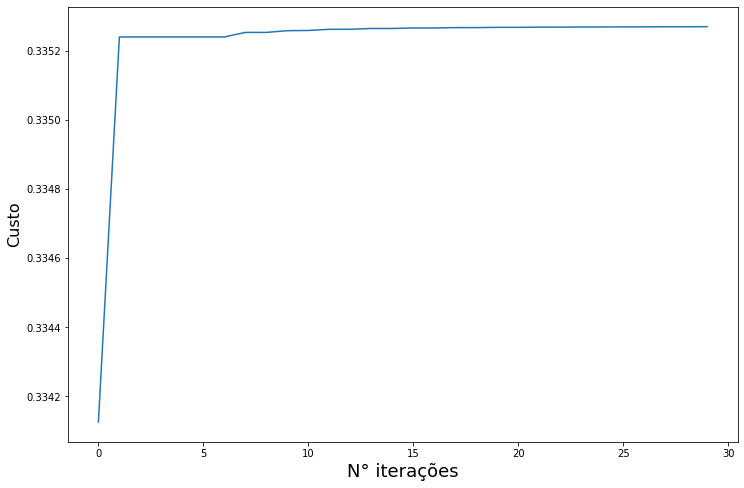

In [63]:
exibir_sumario_resultados(solucao, custos)

Dessa forma, o algoritmo voltou a ser completamente dependente da sua inicialização, mesmo que executado diversas vezes, se o ponto inicial é desfavorável então ele todo se sai mal. Todavia essa abordagem é a que consegue chegar mais próxima do nosso máximo global, pois os passos dados são cada vez menores, gerando chances maiores de atingir o ponto global caso estejamos na "montanha" correta.

Em um problema com mais dimensões essa abordagem pode ser ainda mais benéfica, pois leva em consideração o espaço de busca onde os valores estão se saindo bem e explora com mais calma cada uma das dimensões, apesar de claro, poder se limitar bastante aos pontos locais ao invés de chegar a um global.

# Simulated annealing
O segundo algoritmo utilizado para tentar resolver o problema foi o recozimento simulado, sendo implementado na função *simulated_annealing*. A diferença dele para o Hill Climbing é a probabilidade de aceitar valores negativos, onde quanto mais no início do algoritmo, maior a sua chance de aceitar esse valor negativo.

## Probabilidade
A probabilidade do Simulated Annealing é geralmente dada por uma função exponencial **exp(x)**. Nessa função, elevamos o número de euler ~2.7 a um valor de X, que no nosso caso é o resultado da subtração entre o novo custo e o custo anterior divido pela temperatura: **(x' - x) / T**.
Com isso, a temperatura não só vai diminuindo gradativamente a probabilidade de se aceitar valores negativos como também o quão negativo esse valor pode ser.

### Pros e contras dessa abordagem
Esse algoritmo tem uma tendência a se sair melhor do que o subida da encosta pois permite uma maior exploração do espaço de busca ao aceitar valores negativos. Todavia, ele possui parâmetros que devem ser otimizados para melhor seu funcionamento, sendo eles a **temperatura** e a **taxa de resfriamento**. Esses parâmetros vão afetar diretamente o número de iterações e também a probabilidade de aceitar valores negativos, respectivamente.

A respeito da temperatura, encontrei alguns problemas para definir seu valor, pois uma baixa temperatura resultava em um número de iterações muito reduzido e temperaturas altas deixaram o resultado da função de probabilidade discutido anteriormente sempre próximo a 100%, fazendo com que o algoritmo aceite valores negativos em todas as iterações. Por conta disso, eu implementei uma **função alternativa de probabilidade**.

### Função alternativa de probabilidade
Nessa função, começamos com 100% de probabilidade de aceitar valores negativos e conforme as iterações, vamos diminuindo esse valor.
Essa redução de valor é definida por uma constante e essa constante é definida pelo número de iterações do nosso algoritmo. Um exemplo simples: Se nosso algoritmo vai ter 10 iterações, nossa constante recebe um valor de 10 e a cada iteração nossa probabilidade vai ser subtraída por essa constante, se comportando da seguinte forma: 
1. *p = 100 - 10 = 90*
2. *p = 90 - 10 = 80*

A vantagem de usar essa abordagem é que não precisamos nos preocupar em encontrar um valor de temperatura que se adapte à grandeza do nosso domínio, fazendo com que nossa probabilidade seja genérica para qualquer problema. A desvantagem é que essa probabilidade não leva em consideração a diferença entre o valor atual e o novo valor como nossa função exponencial faz.

A função *get_iteracoes* abaixo calcula quantas iterações nosso algoritmo terá, baseado na temperatura e taxa de resfriamento, para definir o valor da nossa constante de diminuição de probabilidade discutida anteriormente.

In [64]:
def get_iteracoes(temperatura, resfriamento):
    count = 0
    while temperatura > 0.1:
        temperatura = temperatura * resfriamento
        count += 1
    return count

In [65]:
def simulated_annealing(funcao_custo, temperatura = 100.0, resfriamento = 0.95):
    iteracoes = get_iteracoes(temperatura, resfriamento)
    probabilidade = 100
    queda_prob = probabilidade / iteracoes
    solucao = random.random()
    custos = []
    parar_no_plato = 0

    while temperatura > 0.1:
        vizinhos = get_vizinhos(solucao)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            
            if parar_no_plato == 20:
                break

            custo = funcao_custo(vizinhos[i])
            
            if custo >= melhor or random.random() < probabilidade:
                parar_no_plato = parar_no_plato + 1 if solucao_atual == solucao else 0
                melhor = custo
                solucao = vizinhos[i]
        
        probabilidade = probabilidade - queda_prob 
        temperatura = temperatura * resfriamento

    return solucao, custos

O algoritmo foi executado 30 vezes para tentar encontrar os melhores resultados utilizando os parâmetros padrões. Posteriormente serão executados testes para otimizar a temperatura.

In [66]:
custos = []
solucao = []
start_time = time.time()

for i in range(30):
    solucao_tempera_simulada = simulated_annealing(funcao_custo)
    solucao.append(solucao_tempera_simulada[0])
    custos.append(max(solucao_tempera_simulada[1]))
    custo_individual = solucao_tempera_simulada[1]

print("--- %s Segundos ---" % (time.time() - start_time))

--- 0.014808893203735352 Segundos ---


Solução que gerou melhor resultado: 0.0051143377279240865
Melhor custo: 0.9999903006812709
Média de custos: 0.9733648400628446
Desvio padrão: 0.05060193647187416


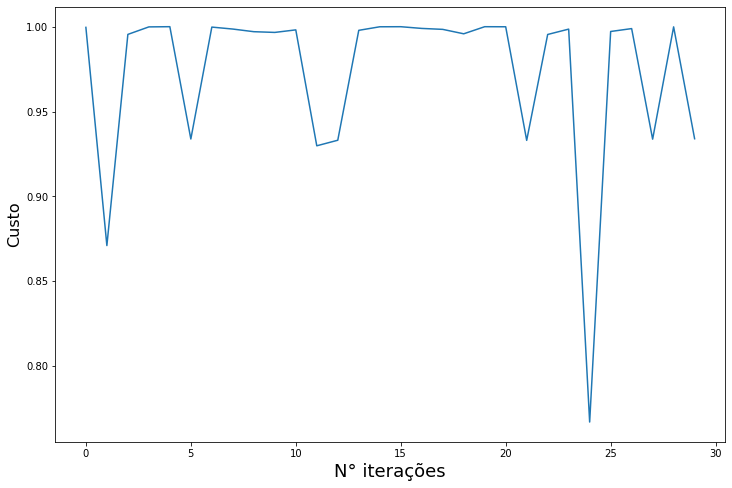

In [67]:
exibir_sumario_resultados(solucao, custos)

O algoritmo de recozimento simulado resultou em uma abordagem consideravelmente mais estável, pois apesar de ter atingido resultados muito semelhantes ao subida da encosta ele consegue atingir o ponto global em boa parte das iterações, sendo este fato refletido em uma média mais alta e no desvio padrão mais baixo. Podemos notar também que a forma alternativa de calcular a probabilidade foi efetiva.

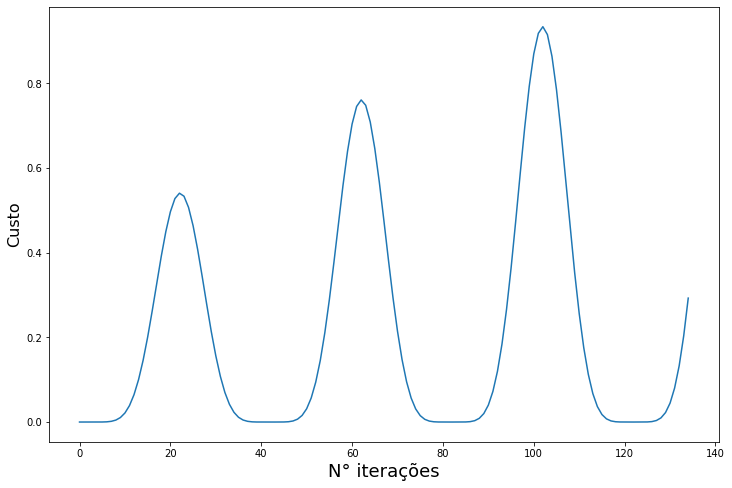

In [68]:
plotar_busca(custo_individual)

Todas as vezes que a função acima for executa teremos um gráfico um pouco diferente, mas a ideia do algoritmo de recozimento sumilado é gerar algumas "montanhas", devido a variação de valores negativos e positivos. É possível que ele termine em um "platô", pois ele chega a um ponto na temperatura onde a probabilidade de aceitar valores negativos é muito baixa.

Para problemas simples como esse, o tempo de execução dos algoritmos é insignificante, mesmo com o recozimento chegando próximo a 140 iterações leva menos de 1 segundo para completar as 30 execuções.

# Algoritmo genético
Por fim, chegamos ao algoritmo genético para tentar resolver esse problema, sendo implementado na função *genetico*.

Minha implementação de algoritmo genético foi um pouco diferente da abordagem vista em aula.
Primeiramente eu optei por usar a representação numérica ao invés de converter os valores para binário, com isso, os operadores genéticos foram personalizados de forma a respeitar esse padrão. 

Nos exemplos vistos em aula, temos uma array (cromossomo) composto pelos genes (cada posição no array), sendo representado dessa forma: [1,0,1,1,0], mas na minha implementação a ideia foi representar cada **INDIVÍDUO** da população como uma possível solução, onde cada dimensão é um gene e o conjunto de dimensões é meu cromossomo.

Sendo assim, nesse problema, eu tenho que meu X é meu gene e também meu cromossomo (pois é um problema de apenas 1 dimensão), ficando representado dessa forma: ```indivíduo = [X]```. No problema que veremos a seguir de duas dimensões (X e Y), a representação fica da seguinte forma: ```indivíduo = [X, Y]```

## Mutação
A mutação é um processo aleatório que ocorre na população, mudando as características de um gene. Para simular esse evento, na minha função chamada *mutacao*, foi feito a aplicação de uma perturbação em um determinado gene. Essa perturbação é uma constante e a operação realizada tem 50% de chance de ser uma somatória e 50% de ser uma subtração. Nenhum operação é realizada caso o gene em questão extrapole os limites do domínio.

In [69]:
def mutacao(solucao, dominio):
    constante = 0.05
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    solucao = list(solucao)

    if random.random() < 0.5:
        if ((gene_mutado - constante) >= dominio[0][0]):
            gene_mutado = gene_mutado - constante
    else:
        if ((gene_mutado + constante) <= dominio[0][1]):
            gene_mutado = gene_mutado + constante

    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado) 
            
    return tuple(solucao)

## Crossover 
Técnica onde os indivíduos da população compartilham os genes, **distribuindo as características** entre eles. Em problemas binários faz sentido compartilhar as características dos nossos indivíduos pais através da troca aleatorizada de genes do cromossomo, todavia nesse caso, meu crossover não poderia ocorrer dessa forma, por se tratar de uma valor numérico. portanto, para gerar um "filho" numérico que compartilhasse as características dos pais, optei por tirar a média dos valores de cada gene.

Seguindo nosso exemplo anterior, supondo que nosso primeiro indivíduo seja o valor de 0.23 e o segundo indivíduo seja 0.85, nosso crossover resulta em um filho com o valor de 0.54. O processo de somatória acontece para todas as dimensões (genes) do meu indivíduo.

In [70]:
def crossover(solucao1, solucao2):
    crossed = [(solucao1[i] + solucao2[i]) / 2 for i in range(len(solucao1))]
    return tuple(crossed)

## Torneio
O torneio foi a forma escolhida para seleção dos indivíduos da população através da função de *get_populacao_torneio*.

A diversidade da população deve variar baseado na quantidade de "competidores" por vez no torneio, a princípio escolhi 3 competidores aleatórios por vez para formar a nova população, isso da uma boa chance de escolher um valor que talvez não seja dos melhores, mas garante uma boa diversidade também. 

A quantidade de indivíduos que serão selecionados no torneio é dada pela metade do tamanho da população subtraída pelo número de elitismo, que são os indivíduos que serão conservados para próxima geração. Portanto se temos que nossa população é de 50 indivíduos e nosso elitismo é de 10% (5 indivíduos), nosso torneio deve selecionar (50 / 2) - 5  = 20 indivíduos. Com isso, teremos 25 indivíduos que serão usados para reprodução sexuada (crossover) para formar nossa população da próxima geração

In [71]:
def get_populacao_torneio(populacao, numero_individuos, objetivo, n_competidores = 3):
        nova_populacao = []
        while len(nova_populacao) < numero_individuos:
            torneio = []

            for i in range(n_competidores):
                torneio.append(populacao[random.randint(0, len(populacao) - 1)])
            
            torneio.sort(reverse=objetivo)
            nova_populacao.append(torneio[0][1])
        
        return nova_populacao

## Elitismo
O elitismo é uma abstração que não ocorre na natureza mas podemos tirar proveitos no ambiente artificial do nosso algoritmo. Aqui, nós escolhemos os melhores indivíduos da nossa população e passamos esses indivíduos para próxima geração, fazendo com que eles sejam conservados em seu estado natural. Optei por escolher os melhores indivíduos me baseando apenas no resultado da função de custo/aptidão.

A função de *get_melhores_individuos*, responsável pelo elitismo, também recebe uma parâmetro de objetivo, para informar se os indivíduos que serão passados para frente são os que tem maior ou menor valor, dependendo se queremos maximizar ou minimizar os valores.

In [72]:
def get_melhores_individuos(custos, n_elitismo, objetivo):
    custos.sort(reverse=objetivo)
    individuos_ordenados = [individuos for (custo, individuos) in custos]
    elite = individuos_ordenados[0:n_elitismo]
    return elite

## Geração da população
O método *gerar_população*, como o próprio nome sugere, tem a missão de criar a nossa população inicial de indivíduos. Essa população possui um número N de indivíduos escolhidos pelo usuário, porém seus valores são aleatórios dentro do domínio. Para tentar criar uma função mais genérica, também é passado uma parâmetro que informa se o valor dos indivíduos deve ser inteiro (em caso de problemas binários) ou não.

In [73]:
def get_populacao(tamanho_populacao, dominio, numeros_inteiros = False):
    populacao = []
    #random.seed(42) #comentar/descomentar para gerar uma seed para os valores "aleatórios"
    for i in range(tamanho_populacao):
        if numeros_inteiros == False:
            solucao = [random.uniform(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        else:
            solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        
        populacao.append(tuple(solucao)) 
        
    return populacao

O algoritmo genético foi feito de forma genérica, para que possa trabalhar tanto com os valores binários como os não binários.

In [74]:
def genetico(funcao_custo, dominio, objetivo = False, tamanho_populacao = 12, p_mutacao = 0.1, 
               elitismo = 0.1, geracoes=8, binario = True):
    
    populacao = get_populacao(tamanho_populacao, dominio, binario)
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao // 2) - numero_elitismo, objetivo)
    
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                f_mutacao = mutacao_binaria if binario == True else mutacao
                populacao.append(f_mutacao(individuos_escolhidos[individuo_selecionado], 
                                          dominio))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                f_crossover = crossover_binario if binario == True else crossover 
                populacao.append(f_crossover(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
    return custos[0][0], custos[0][1]  

--- 0.02651238441467285 Segundos ---
Solução que gerou melhor resultado: (0.1000154601327746,)
Melhor custo: 0.9999998226666605
Média de custos: 0.8391476382490904
Desvio padrão: 0.15375611994789315


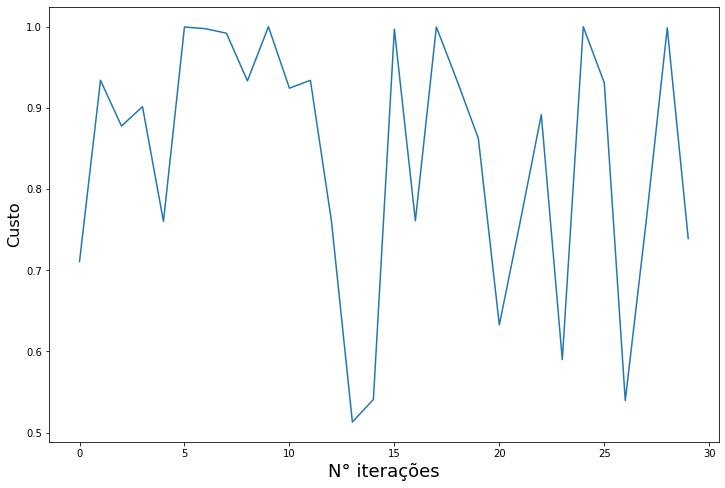

In [75]:
custos = []
solucao = []
dominio = [(0, 1)]
start_time = time.time()

#Objetivo true para maximizar e false para minimizar
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo, dominio, True, binario=False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

print("--- %s Segundos ---" % (time.time() - start_time))
exibir_sumario_resultados(solucao, custos, max)

Podemos observar que o algoritmo genético, como esperado, apresenta um ótimo resultado, conseguindo atingir o máximo global na maioria dos casos, com uma média próximo a 1 em todas as execuções e um baixo desvio padrão. Claro que o desempenho do algoritmo vai variar bastante dependendo dos parâmetros utilizados. Algoritmos com um número maior de parâmetros geralmente são melhores para generalizar problemas, apesar de ser necessário encontrar o melhor conjunto de parâmetros. 

Existem algumas técnicas, geralmente por força bruta ou aleatorização, que nos permitem encontrar melhores parâmetros para se adaptar ao problema, inclusive os próprios algoritmos genéticos são usados muita das vezes para fazer a busca por melhores parâmetros em outros algoritmos como em redes neurais. Nesse caso não foi necessário muito esforço para buscar parâmetros devido à simplicidade do problema. Foi observado que quanto maior a população inicial, maiores as chances de encontrarmos nosso máximo global, devido ao pequeno espaço de busca definido pelo domínio [0,1].

# Qual o problema?
No terceiro problema nós devemos lidar com um problema de duas dimensões, otimizando uma formula matemática com a variável X e Y:

![title](image/formula2.png)

## Objetivo
Minimizar o valor da formula matemática.

## Representação
O domínio do problema é definido por valores em um intervalo de [-5, 5]

## Função de custo
Foi criado uma nova função de custo *funcao_custo_2* que pega o valor das duas dimensões e calcula o custo pelo resultado da fórmula.

In [76]:
def funcao_custo_2(valor):
    x = valor[0]
    y = valor[1]

    custo = (1-x)**2 + (100 * (y - x**2)**2)
    return custo

Não foi necessário fazer mais modificações no algoritmo genético, apenas executá - lo novamente as 30 vezes.

--- 0.04248857498168945 Segundos ---
Solução que gerou melhor resultado: (1.019263538168499, 1.037037632227498)
Melhor custo: 0.0007172403512130573
Média de custos: 15.257310286239553
Desvio padrão: 60.336852281663816


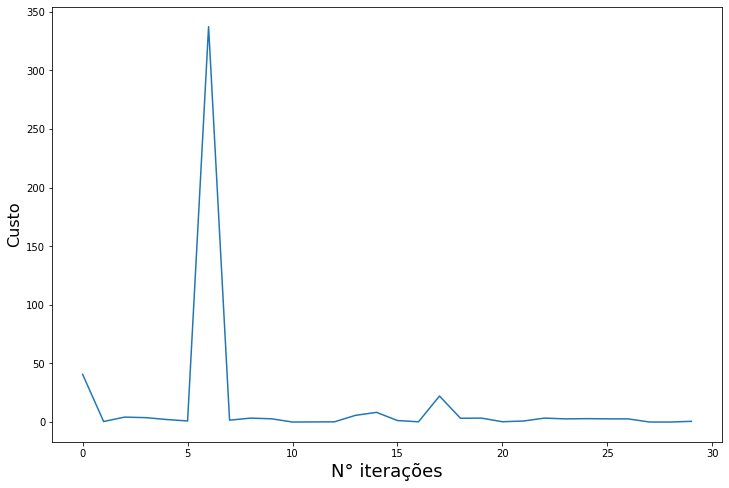

In [77]:
custos = []
solucao = []
dominio = [(-5, 5), (-5, 5)] #domínio de duas dimensões entre -5 e 5
start_time = time.time()
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_2, dominio, False, binario = False,
                                         tamanho_populacao = 16, geracoes = 12)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

print("--- %s Segundos ---" % (time.time() - start_time))
exibir_sumario_resultados(solucao, custos, min)

## Resultados 
O algoritmo genético conseguiu atingir bons resultados na maioria das vezes, chegando a valores de aptidão muito próximos a 0, cumprindo com o objetivo de minimizar o custo.
Porém para chegar a esses resultados foi necessário aumentar o número de gerações para 12 e a população para 16 indivíduos, como era de se esperar, por se tratar de um problema com uma dimensão a mais e também com um domínio maior.

Um novo teste foi feito, dessa vez aumentando o domínio do problema para [- 100, 100].

--- 2.1584665775299072 Segundos ---
Solução que gerou melhor resultado: (1.0, 1.0)
Melhor custo: 0.0
Média de custos: 0.9458314532573124
Desvio padrão: 1.9557128980757978


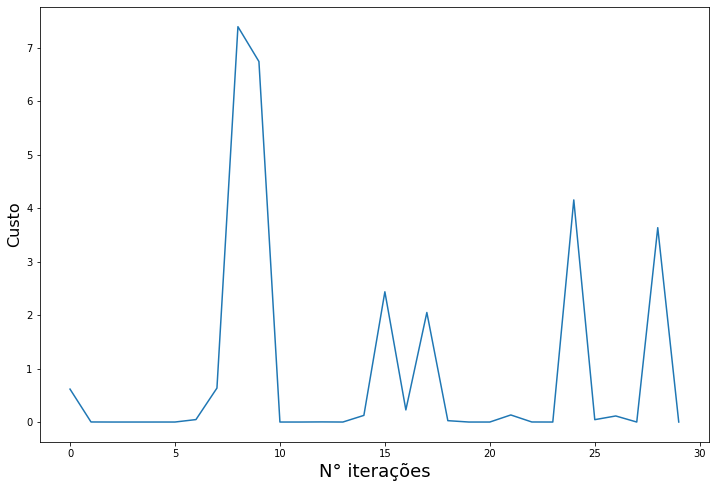

In [78]:
custos = []
solucao = []
dominio = [(-100, 100), (-100, 100)]
start_time = time.time()
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_2, dominio, False, binario = False,
                                         tamanho_populacao = 200, geracoes = 60)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

print("--- %s Segundos ---" % (time.time() - start_time))
exibir_sumario_resultados(solucao, custos, min)

Com esse novo domínio tivemos que aumentar ainda mais o número de gerações, chegando a 60, enquanto a população foi para 200 indivíduos. Uma das grandes vantagens dos algoritmos genéticos é conseguir aumentar a capacidade de generalização apenas mudando os parâmetros.
Com essa configuração de parâmetros conseguimos atingir resultados próximos a zero na maioria das iterações, sendo refletido em uma média próxima a zero. 
Nesse caso o algoritmo, ainda que rápido, demorou cerca de 160 vezes mais em sua execução que o de Hill Climbing e o simulated annealing.

# Qual o problema
Implementação dos algoritmos genéticos para ser capaz de reconhecer o número 0, usando apenas um vetor de números binários, onde o 1 é quando o pixel é branco e o zero ele é preto. Nesse problema, podemos definir um critério de parada a partir do objetivo, pois estamos satisfeitos assim que conseguirmos reconhecer o número 0, diferente dos demais problemas onde apenas tentamos executar até encontrar a melhor solução possível, que é desconhecida.

## Objetivo
Ser capaz de reconhecer o valor 0, **minimizando** a diferença de binários do vetor atual em relação ao vetor correto (que repesenta o número 0).

## Representação
vetor de binários, com 12 posições: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0].

## Nova função de custo
Dessa vez, minha função de custo compara o vetor de exemplo (que é o número exato que eu quero detectar) com o vetor de entrada. A comparação me retorna um valor que diz respeito a quantos pixels existem de diferença entre o número que eu quero ser capaz de reconhecer e o número que foi passado e quanto menor esse valor mais próximos estamos do nosso número de interesse.

In [79]:
def funcao_custo_3(vetor):
    numero_zero = [1, 1, 1, 1,0, 1, 1,0, 1, 1, 1, 1]
    custo = 0
    for i in range(len(vetor)):
        if vetor[i] != numero_zero[i]:
            custo += 1
    return custo

## Nova função de crossover
Também fiz uma nova função para o crossover, permitindo o cruzamento em caso de um array de valores binários, sorteando um valor aleatório para dividir os cromossomos pais e recombinar em um novo cromossomo que será o filho.

In [80]:
def crossover_binario(solucao1, solucao2):
    index_cruzamento = random.randint(0, len(solucao1) -1)
    solucao_resultante = solucao1[0:index_cruzamento] + solucao2[index_cruzamento:len(solucao2)]
    return solucao_resultante

## Nova função de mutação
A função de mutação também fica diferente nesse caso, pois a mudança aplicada no gene do cromossomo não é mais uma subtração ou somatória por uma constante e sim uma mudança no valor binário. Essa mudança então é aplicada de forma aleatória em um dos genes do meu cromossomo, podendo mudar um binário que estava em 0 para 1 e vice versa.

In [81]:
def mutacao_binaria(solucao, dominio):
    solucao = list(solucao)
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    gene_mutado = 1 if gene_mutado == 0 else 0
    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado)
    return tuple(solucao)

In [82]:
custos = []
solucao = []
dominio = [(0, 1)] * 12

for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_custo_3, dominio, False)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

## Melhor imagem obtida
Abaixo podemos ver a melhor imagem que conseguimos chegar na execução do algoritmo, através da transformação do nosso vetor em uma matrix 4x3.

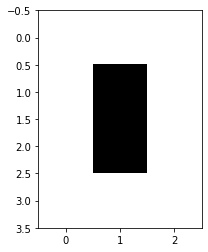

In [83]:
image = np.asmatrix(solucao[custos.index(min(custos))])
image = image.reshape(4, 3)
plt.imshow(image, cmap='gray')

Solução que gerou melhor resultado: (1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1)
Melhor custo: 0
Média de custos: 1.7
Desvio padrão: 0.8999999999999999


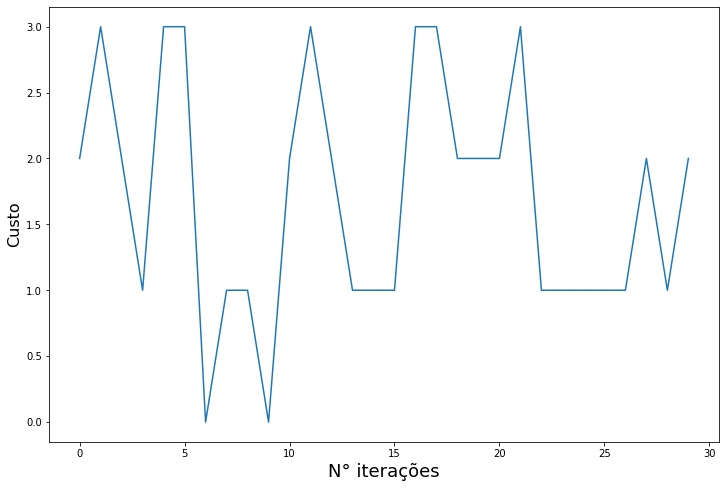

In [84]:
exibir_sumario_resultados(solucao, custos, min)

## Resultados e testes
O algoritmo genético teve uma performance geral interessante para detectar o padrão em questão. Os testes foram feitos usando diferentes parâmetros para observar o comportamento do algoritmo, com um valor de 30 execuções para cada combinação de parâmetros. Ainda assim, cada vez que as 30 execuções acontecerem, teremos resultados levemente diferentes, devido à aleatoriedade dos algoritmos de busca.

## Influência da população e das gerações nos resultados
A ideia inicial foi gerar **variações na população**, com um valor fixo de 5 gerações. Os testes foram feitos com 8, 12, 16 e 20 indivíduos. Utilizar uma maior população irá nos fazer explorar uma área maior no espaço de busca, aumentando a chance de atingir bons resultados, porém com um tempo de convergência do algoritmo.

Depois, variou - se a **quantidade de gerações** (5, 10, 15 e 20) mantendo a mesma população inicial de 8 indivíduos. As gerações são importantes para que os individuos consigam passar pela "evolução natural", sendo essencial para que o modelo consiga convergir, porém com uma população muito pequena para o problema, corremos o risco de convergir para um ponto local ao invés do global.

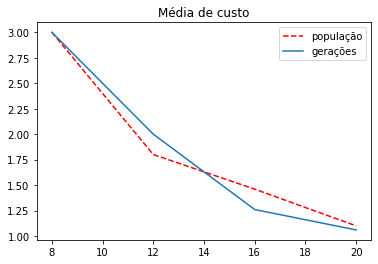

In [85]:
plt.plot([8, 12, 16, 20], [3, 1.8, 1.46, 1.1], 'r--', [8, 12, 16, 20], [3, 2, 1.26, 1.06])
plt.legend(['população', 'gerações'])
plt.title('Média de custo')
plt.show()

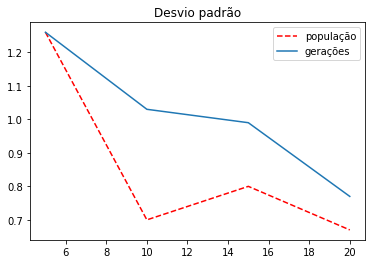

In [86]:
plt.plot([5, 10, 15, 20], [1.26, 0.7, 0.8, 0.67], 'r--', [5, 10, 15, 20], [1.26, 1.03, 0.99, 0.77])
plt.legend(['população', 'gerações'])
plt.title('Desvio padrão')
plt.show()

Podemos observar uma diferença pequena na média de custos. Um ponto interessante, entretanto, é que aumentar a população sem aumentar as gerações nos gerou uma piora nos resultados, pois o algoritmo cria mais pontos no espaço mas não tem tempo de adaptá - los corretamente através da evolução. é notável também, que o desvio padrão das tentativas com maior população é menor, pois como foi dito anteriormente, com mais indivíduos também temos uma chance maior de encontrar um bom ponto no nosso espaço de busca.

Os testes anteriores apenas nos provam a teoria de que, como era de se esperar, o ideal é aumentar esses dois parâmetros de forma linear, pois uma maior exploração, nos exige também um maior tempo de convergência através da adaptação dos pontos nas gerações.

Ainda que pareça óbvio, quando se trata de otimização, cada problema tem suas características, portanto é sempre importante fazer testes antes de assumir hipóteses como verdadeiras. 

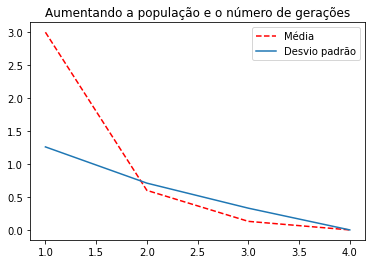

In [87]:
plt.plot([1, 2, 3, 4], [3, 0.6, 0.13, 0], 'r--', [1, 2, 3, 4], [1.26, 0.71, 0.33, 0])
plt.legend(['Média', 'Desvio padrão'])
plt.title('Aumentando a população e o número de gerações')
plt.show()

Dessa vez a população e as gerações cresceram juntas: 8 e 5, 12 e 10, 16 e 15 e 20 e 20 respectivamente, fazendo com que atingíssemos um ponto máximo de convergência na última execução, com uma média e desvio de 0, pois o número 0 foi detectado em todas as 30 execuções.

## Influência na mutação e no crossover nos resultados
Para testar as diferentes mutações e taxas de crossover, utilizei uma população de 8 indivíduos em 5 gerações, por se tratar da minha configuração inicial. A princípio, escolhi de forma arbitrária uma probabilidade de 20% de mutação e 80% de crossover, obtendo uma média de 3 e desvio padrão de 1.26 como vimos anteriormente. Um ponto interessante é que na minha implementação do algoritmo genético, os indivíduos passam obrigatoriamente ou por mutação ou por crossover (menos os que foram escolhidos pelo elitismo).

Ao executar o algoritmo com 100% de probabilidade de mutação obtemos: **média = 2.53 e desvio padrão = 1.3**. O inverso também foi testado, com 100% de probabilidade de crossover, obtendo: **média = 3.5 e desvio padrão = 1.14**. Como podemos observar, aumentar a taxa de crossover ao máximo nos trouxe piores médias, possivelmente causadas por conta dos pontos no espaço se prenderem ao máximo local, já que sem mutação a exploração é menor. Porém, pelo mesmo motivo nos trouxe resultados mais estáveis, com um desvio padrão menor.Já maximizando a mutação, atingimos uma média maior, pois nossos pontos conseguem percorrer mais livremente o espaço de busca, todavia o desvio padrão também foi maior, mostrando a instabilidade que uma abordagem muito exploratória pode trazer para nosso algoritmo.

## Determinando os melhores valores de mutação e crossover
Como o crossover e a mutação são duas variáveis que vão de 0 a 1, podemos usar a força bruta para tentar determinar qual a melhor combinação desses parâmetro para resover nosso problema.  ideia é testar diferentes combinações de probabilidade de mutação e crossover, começando com 100% de chance de crossover e 0% de mutação e incrementando e decrementando respectivamente em 0.05, até que esses valores se invertam, ou seja, se tornem em 100% de chance de acontecer mutação e 0% de crossover.

Uma outra alteração que fiz para melhorar a vizualização gráfica dos resultados foi converter o valor do custo em uma porcentagem de precisão. Lembrando que nosso custo originalmente é a distância de 0 a 12 entre nosso número 0 e o número que o algoritmo tentou gerar de solução. Com isso, ao invés de retornar entre 0 e 12 o retorno se deu entre 0 e 1, onde 1
representa 100% de acerto. Também fixei uma *seed* (semente) na geração dos valores "aleatórios", para que o teste não tenha influência do acaso.

In [88]:
custos = []
dominio = [(0, 1)] * 12
p_mutacao = [-0.05]
crossover = [1.05]

for i in range(int(1 / 0.05) + 1):
    p_mutacao.append(p_mutacao[len(p_mutacao)- 1] + 0.05)
    crossover.append(crossover[len(crossover)- 1] - 0.05)
    solucao_algoritmo_genetico = genetico(funcao_custo_3, dominio, False, p_mutacao = 
                                           p_mutacao[len(p_mutacao) - 1])

    custos.append((12 - solucao_algoritmo_genetico[0]) / 12 ) #convertendo em %

p_mutacao.pop(0)

-0.05

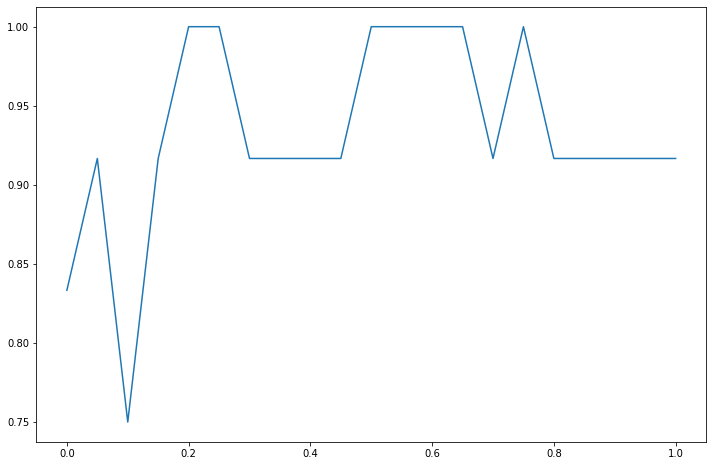

In [89]:
plt.figure(figsize=(12,8))
plt.plot(p_mutacao, custos)
plt.show()

In [90]:
melhores_taxas = [p_mutacao[i] for i, x in enumerate(custos) if x == 1.0]
for i in melhores_taxas:
    print('Probabilidade de mutação', i, 'probabilidade de crossover', 1 - i)

Probabilidade de mutação 0.2 probabilidade de crossover 0.8
Probabilidade de mutação 0.25 probabilidade de crossover 0.75
Probabilidade de mutação 0.49999999999999994 probabilidade de crossover 0.5
Probabilidade de mutação 0.5499999999999999 probabilidade de crossover 0.45000000000000007
Probabilidade de mutação 0.6 probabilidade de crossover 0.4
Probabilidade de mutação 0.65 probabilidade de crossover 0.35
Probabilidade de mutação 0.7500000000000001 probabilidade de crossover 0.2499999999999999


Podemos ver acima os valores de mutação e crossover que geraram os melhores resultados (100% de acerto). Esses valores de probabilidade também são dependentes dos parâmetros que discutimos anteriormente de população e número de gerações, portanto o ideal seria trabalhar otimizando todos os parâmetros de forma conjunta. Existem alguns métodos combinatórios para isso, porém devido à simplicidade do problema, como já foi observado, não é uma abordagem necessária nesse caso, pois os parâmetros conseguem facilmente serem otimizados de forma manual para atingirmos nosso ponto global.

# Algoritmos genéticos para otimização de parâmetros
Como foi dito anteriormente, o parâmetro mais complicado de se otimizar, mesmo que em um espaço de solução pequeno, foi o da **temperatura** do nosso algoritmo de recozimento simulado. Pensando nisso, implementei uma versão levemente modificada do algoritmo genético e do recozimento, para tentar encontrar um bom parâmetro para nossa temperatura. A ideia é a mesma seguida anteriormente, vamos criar uma população inicial aleatória de vários indivíduos candidatos para ser a minha temperatura. O domínio para a temperatura foi definido entre 0 e 100.

Dessa vez, o cálculo de probabilidade usado foi o **exponencial**, pois como vimos anteriormente, ele é mais dificil de ser adequado a temperatura mas também é mais eficaz ao sensibilizar o modelo para aceitar ou não valores negativos. A expectativa é que com essa otimização iremos encontrar um valor de temperatura que se adapte bem a essa formula nesse problema.

In [91]:
def simulated_annealing_otimizacao(funcao_custo, temperatura = 20, resfriamento = 0.95):
    probabilidade = 100
    solucao = random.random()
    custos = []
    parar_no_plato = 0

    while temperatura > 0.01:
        vizinhos = get_vizinhos(solucao)
        
        atual = funcao_custo(solucao)
        melhor = atual 
        solucao_atual = solucao
        custos.append(atual)

        for i in range(len(vizinhos)):
            
            if parar_no_plato == 20:
                break

            custo = funcao_custo(vizinhos[i])
            
            if custo >= melhor or random.random() < probabilidade:
                parar_no_plato = parar_no_plato + 1 if solucao_atual == solucao else 0
                melhor = custo
                solucao = vizinhos[i]

        probabilidade = pow(math.e, (-custo - melhor) / temperatura) 
        temperatura = temperatura * resfriamento

    return max(custos)

In [92]:
def genetico_otimizacao(funcao_custo, dominio, objetivo = False, tamanho_populacao = 50, p_mutacao = 0.2, elitismo = 0.1, geracoes=20):
    populacao = get_populacao(tamanho_populacao, dominio, True)
    
    numero_elitismo = int(elitismo * tamanho_populacao)
    
    for i in range(geracoes):
        custos = [(simulated_annealing_otimizacao(funcao_custo, individuo[0]), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao // 2) - numero_elitismo, objetivo)

        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(mutacao(individuos_escolhidos[individuo_selecionado], dominio))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                populacao.append(crossover(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
    return custos[0][0], custos[0][1]

In [93]:
custos = []
solucao = []
dominio = [(1, 100)]

for i in range(30):
    solucao_algoritmo_genetico = genetico_otimizacao(funcao_custo, dominio, True)
    solucao.append(solucao_algoritmo_genetico[1])
    custos.append(solucao_algoritmo_genetico[0])

exibir_sumario_resultados(solucao, custos, max)

TypeError: 'list' object is not callable

Nosso algoritmo genético nos traz como resultado a temperatura que **melhor se adequou** ao nosso problema (67 nesse caso). Não se trata de uma resposta absoluta, pois o algoritmo em si é bastante estocástico, mas foi a temperatura que conseguiu os melhores resultados no decorrer da maioria das iterações. Poderíamos tirar também a média das temperaturas, para conseguir um valor mais estável, porém de qualquer forma a ideia foi mostrar como os algoritmos genéticos são competentes para buscar uma solução em um espaço de busca e otimizar parâmetros de outros algoritmos.

# Conclusões
Todos os algoritmos de otimização alcançaram o melhor resultado possível nos problemas que enfrentamos aqui, todavia não podemos dizer que são todo iguais. O algoritmo genético foi o que se mostrou mais estável, conseguindo atingir um resultado excelente na maioria das iterações, sendo seguido do recozimento simulado e por último o Hill Climbing. No geral, é vantajoso escolher um algoritmo com esse tipo de comportamento, pois bons resultados não ficam tão dependetes do acaso, principalmente em problemas mais complexos, onde o espaço de busca tem um domínio maior e com mais dimensões.

O custo dessa estabilidade e robustez que esses algoritmos trazem é a otimização dos parâmetros, sendo necessário encontrar 2 bons parâmetros no recozimento e 5 no algoritmo genético, se transformando em uma tarefa mais custosa, não só em tempo nos testes mas também computacionalmente.

Entender os algoritmos nos permitem escolher o problema em que cada um pode acabar se saindo melhor e também criar implementações alternativas ao algoritmo original, para se adaptar ao nosso problema em específico.